# Scalable and Cloud Programming - ClassifAI

Il progetto vede lo sviluppo di una **decision forest** composta da 11 decision trees. Ognuno di quest'ultimi rappresenta un albero in grado di effettuare **binary classification** su una data categoria assegnata. Unendo assieme gli alberi, formando una *forest*, permette di avere un modello in grado di effettuare **multiclass classification**.  

Il dataset utilizzato all'interno di questo progetto è stato recuperato da **Kaggle**, al seguente URL: <br>
https://www.kaggle.com/datasets/linkanjarad/contexttopic-classification-from-statement <br>

Lo pseudocodice utilizzato come base di partenza per lo sviluppo del progetto è disponibile al seguente link: <br>
https://article.nadiapub.com/IJDTA/vol7_no1/5.pdf <br> <br>

Esso conterrà frasi classificate in 11 diverse categorie, di seguito riportate: <br>

  * Animals
  * Compliment
  * Education
  * Health
  * Heavy
  * Joke
  * Love
  * Politics
  * Religion
  * Science
  * Self

#### Mount di Google Drive, su cui sono stati caricati il dataset e il jar del progetto.



In [ ]:
from google.colab import drive
from google.colab import auth

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


#### Definizione delle proprietà del progetto e inizializzazione della shell.

In [ ]:
PROJECT_ID = "classifai-reserve"
BUCKET_NAME = "classifai-r-bucket"
CLUSTER_REGION = "us-central1"

auth.authenticate_user(project_id=PROJECT_ID)
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


## Caricamento del csv e jar sul bucket

In [ ]:
!gsutil -m cp -r /content/drive/MyDrive/Scalable/Context.csv gs://{BUCKET_NAME}/assets/
!gsutil -m cp -r /content/drive/MyDrive/Scalable/ClassifAI.jar gs://{BUCKET_NAME}/

## Definizione delle configurazioni e creazione di clusters e jobs <br>
Per ogni configurazione, verrà creato un relativo cluster con specifico numero di workers e cores, per poi procedere con il lancio del job. <br>
Al termine, il cluster verrà eliminato, in modo da risparmiare risorse.

Il JobID assegnato segue il formato: W-C-O-T, acronimi rispettivamente di workers, cores, occurrences, treeDepth. Il loro utilizzo ha permesso di recuperare comodamente i parametri di esecuzione in fase di **describe**.

In [ ]:
# num_workers, num_cores, min_occurs, max_tree_depth
configs = [
    ["2", "2", "500", "20"],
    ["2", "8", "500", "20"],
    ["3", "8", "500", "20"],
    ["6", "4", "500", "20"],
    ["2", "2", "50", "10"],
    ["2", "8", "50", "10"],
    ["3", "8", "50", "10"],
    ["6", "4", "50", "10"],
    ["2", "2", "50", "20"],
    ["2", "8", "50", "20"],
    ["3", "8", "50", "20"],
    ["6", "4", "50", "20"],
    ["3", "8", "1000", "10"]
]

for config in configs:
  num_workers = config[0]
  num_cores = config[1]
  min_occurs = config[2]
  max_tree_depth = config[3]

  cluster_name = f"cluster-scalable-{num_workers}-{num_cores}"

  !gcloud dataproc clusters create {cluster_name} \
    --enable-component-gateway \
    --region={CLUSTER_REGION} \
    --master-machine-type n2-standard-4 \
    --master-boot-disk-type pd-ssd \
    --master-boot-disk-size 64 \
    --num-workers={num_workers} \
    --worker-machine-type e2-standard-{num_cores} \
    --worker-boot-disk-size 64 \
    --project={PROJECT_ID} \
    --properties="capacity-scheduler:yarn.scheduler.capacity.resource-calculator=org.apache.hadoop.yarn.util.resource.DominantResourceCalculator"

  jobProps = f"spark.dynamicAllocation.enabled=true,spark.serializer=org.apache.spark.serializer.KryoSerializer,spark.executor.cores={num_cores},spark.driver.cores={num_cores},spark.executor.instances={num_workers},spark.default.parallelism={num_workers}"

  jobID = f"W{num_workers}-C{num_cores}-O{min_occurs}-T{max_tree_depth}"

  !gcloud dataproc jobs submit spark \
    --id={jobID} \
    --cluster={cluster_name} \
    --region={CLUSTER_REGION} \
    --properties={jobProps} \
    --jar=gs://{BUCKET_NAME}/ClassifAI.jar -- actualPath=gs://{BUCKET_NAME}/assets minOccurs={min_occurs} treeMaxDepth={max_tree_depth} mapReduce=true computeDF=false computeTrees=true localExec=false

  !gcloud dataproc clusters delete {cluster_name} \
    --region={CLUSTER_REGION}

Waiting on operation [projects/classifai-reserve/regions/us-central1/operations/db4fe142-b1fa-33a5-8c50-dbae757b1c88].

Created [https://dataproc.googleapis.com/v1/projects/classifai-reserve/regions/us-central1/clusters/cluster-scalable-6-4] Cluster placed in zone [us-central1-c].
Job [W6-C4-O50-T20] submitted.
Waiting for job output...
Received arguments: Array(actualPath=gs://classifai-r-bucket/assets, minOccurs=50, treeMaxDepth=20, mapReduce=true, computeDF=false, computeTrees=true, localExec=false)
12:17:52 Arguments selected:
localExec --> false
actualPath --> gs://classifai-r-bucket/assets
computeDF --> false
minOccurs --> 50
mapReduce --> true
computeTrees --> true
treeMaxDepth --> 20
24/04/11 12:17:53 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/11 12:17:53 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/11 12:17:53 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
24/04/11 12:17:53 INFO org.apache.spark.SparkEnv:

Dopo aver terminato l'esecuzione dei job, sarà effettuata un'analisi sui risultati. <br>
Per ogni configurazione, tramite il comando **describe**, verranno recuperati gli estremi temporali di esecuzione di ogni job, che verranno mostrati nei successivi grafici.

In [ ]:
import yaml
import math
from datetime import datetime

# O[minOccurs]-T[treeMaxDepth] -> time_diff_list
times = {}

for tree_conf in ["O500-T20", "O50-T10", "O50-T20"]:
  time_diff_list = []

  for nodes_conf in ["W2-C2", "W2-C8", "W6-C4", "W3-C8"]:
    job_ID = f"{nodes_conf}-{tree_conf}"
    !gcloud dataproc jobs describe {job_ID} --region={CLUSTER_REGION} > /content/drive/MyDrive/Scalable/{job_ID}.yaml

    with open(f'/content/drive/MyDrive/Scalable/{job_ID}.yaml') as file:
        obj = yaml.load(file, Loader=yaml.Loader)

    finish_time = datetime.strptime(obj['status']['stateStartTime'], "%Y-%m-%dT%H:%M:%S.%fZ")

    for state in obj['statusHistory']:
        if state['state'] == 'RUNNING':
            start_time = datetime.strptime(state['stateStartTime'], "%Y-%m-%dT%H:%M:%S.%fZ")

    time_diff = math.floor(float((finish_time - start_time).total_seconds() / 60))
    time_diff_list.append(time_diff)

  times[tree_conf] = time_diff_list


## Plot dei risultati dell'analisi dei log. <br>
Esso permette di visualizzare diversi fenomeni: <br>
  * Un numero crescente di cores (totali) permette di ridurre i tempi di esecuzione dell'algoritmo nella versione MapReduce, essendo quest'ultimo parallelizzabile.
  * Non sempre un numero maggiore di worker corrisponde a tempi minori di esecuzione.

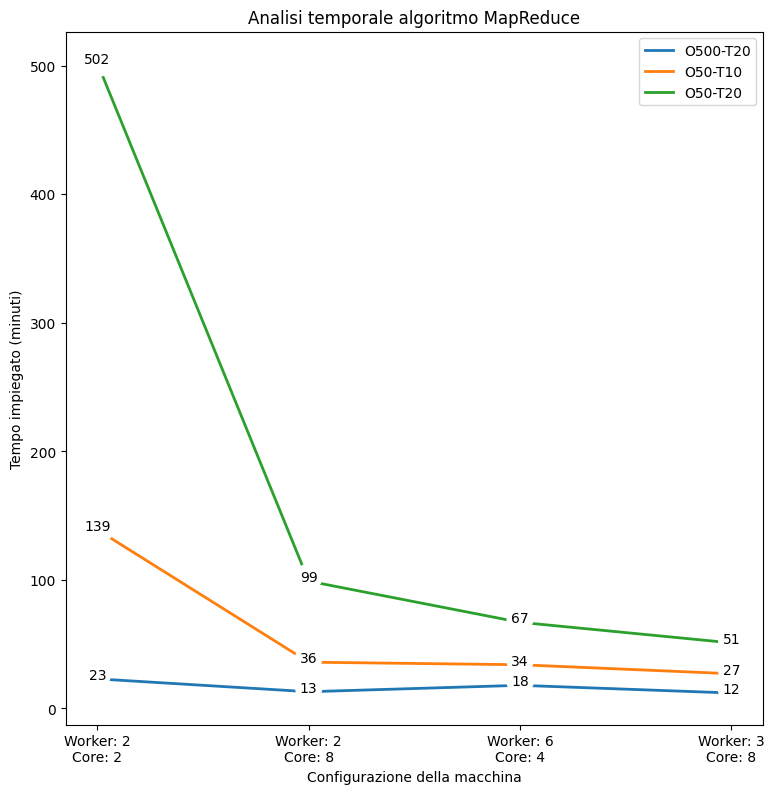

In [ ]:
import matplotlib.pyplot as plt

x_labels = ["Worker: 2\nCore: 2", "Worker: 2\nCore: 8", "Worker: 6\nCore: 4", "Worker: 3\nCore: 8"]

fig, ax = plt.subplots(figsize=(9,9))

for tree_conf, time_diff_list in times.items():
    ax.plot(x_labels, time_diff_list, label=tree_conf, linewidth=2)

    for i, time_diff in enumerate(time_diff_list):
      ax.text(i, time_diff, str(time_diff), ha='center', bbox=dict(facecolor='white', edgecolor='white', boxstyle='circle'))

ax.set_title('Analisi temporale algoritmo MapReduce')
ax.set_xlabel('Configurazione della macchina')
ax.set_ylabel('Tempo impiegato (minuti)')

ax.legend()

plt.show()

## Analisi temporale algoritmo sequenziale vs MapReduce
Il seguente istogramma mette a confronto (a parità di cluster) l'algoritmo in modalità sequenziale e MapReduce. Sono stati impostati i parametri **minOccurs** e **maxTreeDepth** a 1000 e 10, rispettivamente. <br>
Il cluster impiegato è composto da 3 workers, aventi 8 cores ciascuno. <br>
Ad ogni modo, il grafico mostra come l'approccio MapReduce riduca di quasi 15 volte i tempi di esecuzione.

In [ ]:
import yaml
import math
from datetime import datetime

job_list = ["W3-C8-O1000-T10", "W3-C8-O1000-T10-seq"]
time_diff_list = []

for job_ID in job_list:
  !gcloud dataproc jobs describe {job_ID} --region={CLUSTER_REGION} > /content/drive/MyDrive/Scalable/{job_ID}.yaml

  with open(f'/content/drive/MyDrive/Scalable/{job_ID}.yaml') as file:
      obj = yaml.load(file, Loader=yaml.Loader)

  finish_time = datetime.strptime(obj['status']['stateStartTime'], "%Y-%m-%dT%H:%M:%S.%fZ")

  for state in obj['statusHistory']:
      if state['state'] == 'RUNNING':
          start_time = datetime.strptime(state['stateStartTime'], "%Y-%m-%dT%H:%M:%S.%fZ")

  time_diff = math.floor(float((finish_time - start_time).total_seconds() / 60))
  time_diff_list.append(time_diff)

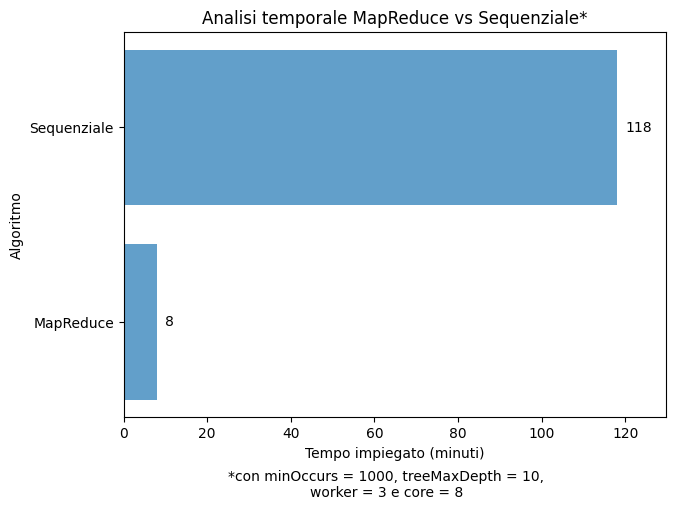

In [ ]:
import matplotlib.pyplot as plt

x_values = ["MapReduce", "Sequenziale"]
y_values = time_diff_list

plt.subplots(figsize=(7,5))

plt.barh(x_values, y_values, color='tab:blue', alpha=0.7)

for i, v in enumerate(y_values):
    plt.text(v + 2, i, str(v), va='center', color='black')

plt.ylabel('Algoritmo')
plt.xlabel('Tempo impiegato (minuti)')

plt.title('Analisi temporale MapReduce vs Sequenziale*')
plt.figtext(0.5, -0.05, '*con minOccurs = 1000, treeMaxDepth = 10,\nworker = 3 e core = 8', ha='center', fontsize=10)

plt.xlim(0, max(y_values) * 1.1)

plt.show()